# Can I gain your attention?

XSpec has the [gain](https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/XSgain.html) command that lets you shift the energy scale of your instrument in a somewhat ad-hoc manner: it allows you to change the energy mapping through the equation

$E^\prime = E / \rm{slope} - \rm{intercept}$

Surely we can do this in Sherpa? Possibilities include

- adjust the ARF and RMF data files on disk
- adjust the data after loading them in
- do something a tad more complex...

As the first two options are boring, we could create a convolution-style model which evaluates the model expression it wraps using the shifted energy range. This could be a generic class but let's just do it for XSpec models, as it simplifies things (e.g. I know how many independent axes are expected, and the units of the data).

---

**UNFORTUNATELY**, although initial comparisons with XSPEC suggested success, more-detailed has shown differences, since XSPEC manually goes and regrids the responses. I need to mull over this for a while to understand what the differences are (is it just the re-gridding or something else). *Darn it* .........

---

This notebook has been run with CIAO 4.16, which uses XSPEC 12.13.1e, and then Sherpa 4.18.0 with XSPEC 12.15.0d:

In [1]:
# Because I have just read https://discuss.python.org/t/please-make-package-version-go-away/58501 I won't use
# sherpa.__version__
#
import importlib
importlib.metadata.version('sherpa')

'4.18.0'

In [2]:
from sherpa.astro import xspec
xspec.get_xsversion()

'12.15.0d'

If you have installed the latest - as of October 2025 - XSPEC data directory but are using a version of XSPEC before 12.15.1 (unfortunately, Sherpa 4.18.0 only supports 12.15.0 and earlier) then you may have problems with APEC models, as the version numbers need updating:

In [3]:
xspec.set_xsxset("APECROOT", "3.1.3")
xspec.set_xsxset("NEIAPECROOT", "3.1.3")

In [4]:
import numpy as np

import matplotlib.pyplot as plt

# Setting up the model

We can write the model pretty easily, although we overload the `calc` method since this model **only** changes the grid passed to the wrapped model (`rhs` in the `calc` call) and does not actually do any other calculation.

In [5]:
from sherpa.models.parameter import Parameter

class XSGainShift(xspec.XSConvolutionKernel):
    """Shift the energy grid used by the wrapped model.

    If the model is evauated on a grid of energy bins
    (elo, ehi) then the wrapped model is evaluated on the
    grid (elo/slope - intercept, ehi/slope - intercept).

    Attributes
    ----------
    slope
    intercept
    """

    def __init__(self, name="xsgainshift"):
        # could use XSParameter but doesn't seem worth it
        self.slope = Parameter(name, "slope", 1, min=0, max=10, hard_min=0, hard_max=20, frozen=True)
        self.intercept = Parameter(name, "intercept", 0, min=-1000, max=1000, frozen=True, units='keV')
        super().__init__(name, (self.slope, self.intercept))

    # overload calc as it isn't the normal behaviour
    def calc(self, pars, rhs, *args, **kwargs):
        """Evaluate rhs on the shifted grid."""

        nargs = len(args)
        if nargs != 2:
            raise TypeError(f"args must be elo,ehi but sent ${nargs} vaule(s)")

        elo = np.asarray(args[0])
        ehi = np.asarray(args[1])
        if elo[0] >= elo[-1]:
            raise RuntimeError("can not handle wavelengths at the moment")
            
        elo2 = elo / self.slope.val - self.intercept.val
        ehi2 = ehi / self.slope.val - self.intercept.val

        # TODO:
        # - this should hide those bins which end up being <= 0
        
        # Get the parameters for rhs
        assert len(pars) >= 2  # in reality this could be '> 2'
        rpars = pars[2:]
        return rhs(rpars, elo2, ehi2, **kwargs)

# WARNING

I haven't really checked this to see if it is doing what it's meant to be doing. Caveat emptor. But you haven't paid anything for this, so caveat freebee. 

# How do I use this?

First let us create a model to shift - in this case an
[absorbed](https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/XSmodelPhabs.html) 
[apec](https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/XSmodelApec.html)
model, where the absorption is fairly low (`0.1`) and the gat temperature is high enough to have plenty of lines (e.g. the Fe complex around 6.7 keV):

In [6]:
cpt1 = xspec.XSphabs("cpt1")
cpt2 = xspec.XSapec("cpts")

orig_model = cpt1 * cpt2
cpt1.nh = 0.1
cpt2.kt = 6
cpt2.redshift = 0

In [7]:
print(orig_model)

cpt1 * cpts
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   cpt1.nH      thawed          0.1            0        1e+06 10^22 atoms / cm^2
   cpts.kT      thawed            6        0.008           64        keV
   cpts.Abundanc frozen            1            0            5           
   cpts.Redshift frozen            0       -0.999           10           
   cpts.norm    thawed            1            0        1e+24           


We can evaluate this model on the "actual" grid (that would be taken from the PHA response but here is just 0.1 to 10 keV with a bin width of 2 eV):

In [8]:
egrid = np.arange(0.1, 10, 0.002)
elo = egrid[:-1]
ehi = egrid[1:]
emid = (elo + ehi) / 2

Here is the model value (the `funny units` are photon/cm$^2$ in this particular case):

In [9]:
yorig = orig_model(elo, ehi)

Reading APEC data from 3.1.3



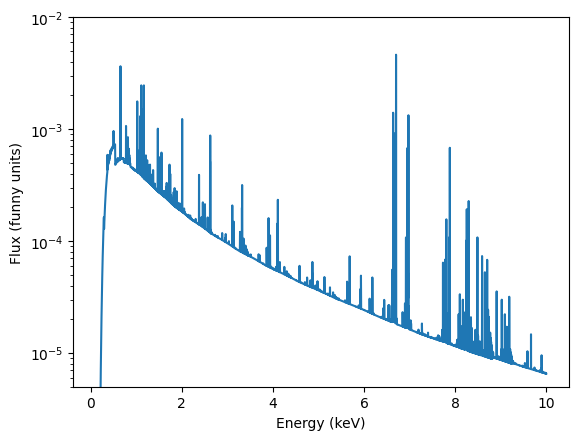

In [10]:
plt.plot(emid, yorig)
plt.xlabel("Energy (keV)")
plt.ylabel("Flux (funny units)")
plt.yscale('log')
plt.ylim(5e-6, 1e-2);

We can create a gain-shift model in a similar manner to the `XSphabs` and `XSapec` models:

In [11]:
gain = XSGainShift("gain")

In [12]:
print(gain)

gain
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   gain.slope   frozen            1            0           10           
   gain.intercept frozen            0        -1000         1000        keV


The magic sauce here is to apply this model to the model expression we want to shift:

In [13]:
shifted_model = gain(orig_model)

Printing the model shows the combined set of parameters (the slope and intercept and then the parameters from the wrapped model):

In [14]:
print(shifted_model)

gain(cpt1 * cpts)
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   gain.slope   frozen            1            0           10           
   gain.intercept frozen            0        -1000         1000        keV
   cpt1.nH      thawed          0.1            0        1e+06 10^22 atoms / cm^2
   cpts.kT      thawed            6        0.008           64        keV
   cpts.Abundanc frozen            1            0            5           
   cpts.Redshift frozen            0       -0.999           10           
   cpts.norm    thawed            1            0        1e+24           


We can evaluate the model in the same way we did for `orig_model`. In this case, since $\rm{slope} \equiv 1$ and $\rm{intercept} \equiv 0$, the result should be the same:

In [15]:
y2 = shifted_model(elo, ehi)

print(f"Are they the same?  {(y2 == yorig).all()}")

Are they the same?  True


We can now check out the behaviour. First a straight shift - here by 0.1 keV:

In [16]:
gain.intercept = 0.1

In [17]:
yshift1 = shifted_model(elo, ehi)

Plotting the data. we can see that the shifted values are all to the right of the original ones.

Note that the first bin is likely because it represents `(0, 0.002)` keV, and that may cause fun behaviour from the model. The `XSGainShift` model should really handle this case better:

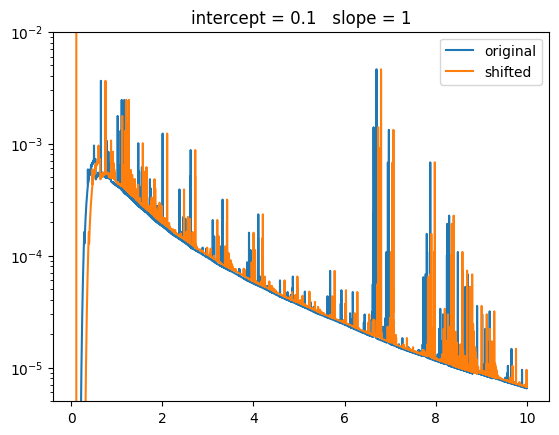

In [18]:
plt.plot(emid, yorig, label="original")
plt.plot(emid, yshift1, label="shifted")

plt.yscale("log")
plt.ylim(5e-6, 1e-2)
plt.title("intercept = 0.1   slope = 1")  
plt.legend();

We can also apply a slope - here `0.98` - which changes the relative shift as energy changes:

In [19]:
gain.slope = 0.98

In [20]:
yshift2 = shifted_model(elo, ehi)

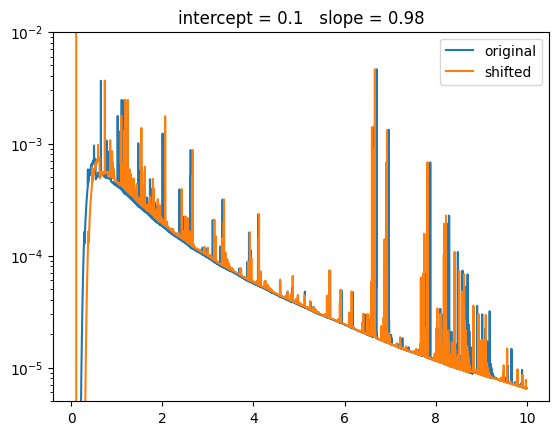

In [21]:
plt.plot(emid, yorig, label="original")
plt.plot(emid, yshift2, label="shifted")

plt.yscale("log")
plt.ylim(5e-6, 1e-2)
plt.title("intercept = 0.1   slope = 0.98")  
plt.legend();

# Use with the UI layer

Let's try this in a "UI" session, as that's the easiest way to add a response. We are going to use the "random" dataset I already have here in this notebook directory.

In [22]:
from sherpa.astro import ui

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


Let's tell Sherpa about this model:

In [23]:
[m for m in ui.list_models() if m.find("gain") > -1]

[]

In [24]:
ui.add_model(XSGainShift)

In [25]:
[m for m in ui.list_models() if m.find("gain") > -1]

['xsgainshift']

In [26]:
ui.load_pha("data/pha/3c273.pi")
ui.notice(0.3, 6)
ui.subtract()

statistical errors were found in file 'data/pha/3c273.pi'
but not used; to use them, re-read with use_errors=True
read ARF file data/pha/3c273.arf
read RMF file data/pha/3c273.rmf
statistical errors were found in file 'data/pha/3c273_bg.pi'
but not used; to use them, re-read with use_errors=True
read background file data/pha/3c273_bg.pi
dataset 1: 0.00146:14.9504 -> 0.2482:6.57 Energy (keV)


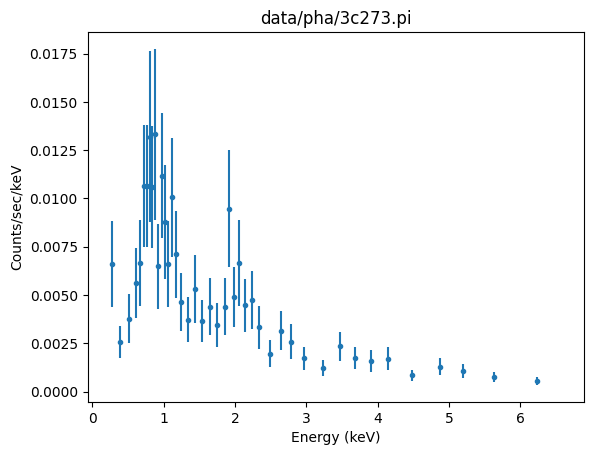

In [27]:
ui.plot_data()

In [28]:
ui.set_source(ui.xsphabs.gal * ui.xsapec.src)

In [29]:
ui.fit()

Dataset               = 1
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 2.94191e+08
Final fit statistic   = 33.6153 at function evaluation 229
Data points           = 43
Degrees of freedom    = 40
Probability [Q-value] = 0.751791
Reduced statistic     = 0.840382
Change in statistic   = 2.94191e+08
   gal.nH         4.29482e-05  +/- 0.0152951   
   src.kT         4.34608      +/- 0.645623    
   src.norm       0.00050219   +/- 2.92471e-05 


In [30]:
# Just to check
ui.fit()

Dataset               = 1
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 33.6153
Final fit statistic   = 33.6066 at function evaluation 193
Data points           = 43
Degrees of freedom    = 40
Probability [Q-value] = 0.752134
Reduced statistic     = 0.840166
Change in statistic   = 0.0086292
   gal.nH         0            +/- 0.0149664   
   src.kT         4.35751      +/- 0.581335    
   src.norm       0.000501779  +/- 2.92942e-05 


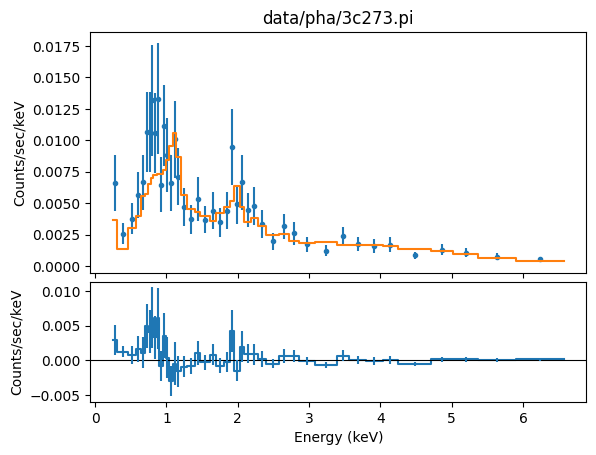

In [31]:
ui.plot_fit_resid()

Let's just check the statistic before we apply the gain:

In [32]:
ui.calc_stat()

33.60663371899836

Now we can apply the gain shift:

In [33]:
ui.set_source(xsgainshift.gain(gal * src))

In [34]:
print(ui.get_source())

xsgainshift.gain(xsphabs.gal * xsapec.src)
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   gain.slope   frozen            1            0           10           
   gain.intercept frozen            0        -1000         1000        keV
   gal.nH       thawed            0            0        1e+06 10^22 atoms / cm^2
   src.kT       thawed      4.35751        0.008           64        keV
   src.Abundanc frozen            1            0            5           
   src.Redshift frozen            0       -0.999           10           
   src.norm     thawed  0.000501779            0        1e+24           


The statistic should be the same as there's been no gain shift applied (modulo some possible numeric noise):

In [35]:
ui.calc_stat()

33.60663371899836

In [36]:
ui.fit()

Dataset               = 1
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 33.6066
Final fit statistic   = 33.6027 at function evaluation 191
Data points           = 43
Degrees of freedom    = 40
Probability [Q-value] = 0.752289
Reduced statistic     = 0.840068
Change in statistic   = 0.00391502
   gal.nH         0            +/- 0.0149542   
   src.kT         4.35456      +/- 0.580911    
   src.norm       0.000502115  +/- 2.92943e-05 


If we thaw the gain then we can fit this - I would hope there's no significant change - ie the `intercept` and `slope` should be close ot `0` and `1` respectively, but I can't guarantee that:

In [37]:
ui.thaw(gain)

In [38]:
print(ui.get_source())

xsgainshift.gain(xsphabs.gal * xsapec.src)
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   gain.slope   thawed            1            0           10           
   gain.intercept thawed            0        -1000         1000        keV
   gal.nH       thawed            0            0        1e+06 10^22 atoms / cm^2
   src.kT       thawed      4.35456        0.008           64        keV
   src.Abundanc frozen            1            0            5           
   src.Redshift frozen            0       -0.999           10           
   src.norm     thawed  0.000502115            0        1e+24           


In [39]:
ui.fit()

Dataset               = 1
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 33.6027
Final fit statistic   = 30.2796 at function evaluation 300
Data points           = 43
Degrees of freedom    = 38
Probability [Q-value] = 0.809463
Reduced statistic     = 0.796832
Change in statistic   = 3.3231
   gain.slope     0.984371     +/- 0.00256275  
   gain.intercept   0.0486706    +/- 0.0119126   
   gal.nH         0            +/- 0.00740727  
   src.kT         4.48646      +/- 0.600399    
   src.norm       0.00048299   +/- 2.69093e-05 


In [40]:
ui.conf()

gal.nH lower bound:	-----
src.norm lower bound:	-2.25211e-05
gal.nH upper bound:	0.00222722
src.kT lower bound:	-0.553144
src.kT upper bound:	0.578521
gain.intercept lower bound:	-0.0178723
src.norm upper bound:	2.9559e-05
gain.slope -: WARNING: The confidence level lies within (9.637049e-01, 9.637021e-01)
gain.slope lower bound:	-0.0206677
gain.intercept +: WARNING: The confidence level lies within (2.420407e-01, 2.454846e-01)
gain.intercept upper bound:	0.195092
gain.slope +: WARNING: The confidence level lies within (1.048369e+00, 1.050869e+00)
gain.slope upper bound:	0.0652477
Dataset               = 1
Confidence Method     = confidence
Fitting Method        = levmar
Statistic             = chi2gehrels
confidence 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   gain.slope       0.984371   -0.0206677    0.0652477
   gain.intercept    0.0486706   -0.0178723     0.195092
   gal.nH               

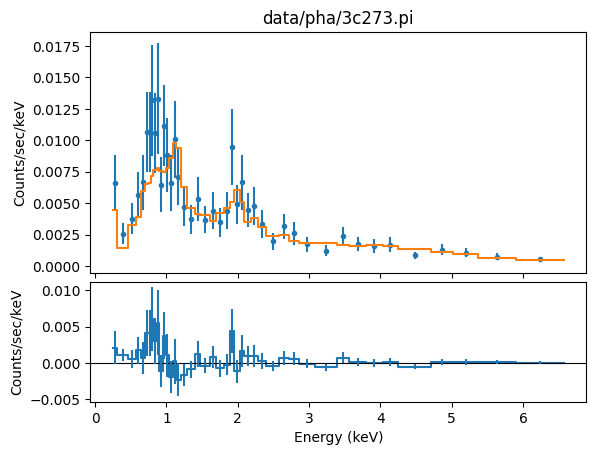

In [41]:
ui.plot_fit_resid()

In [42]:
ui.covar()

Dataset               = 1
Confidence Method     = covariance
Fitting Method        = levmar
Statistic             = chi2gehrels
covariance 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   gain.slope       0.984371  -0.00222114   0.00222114
   gain.intercept    0.0486706   -0.0139661    0.0139661
   gal.nH                  0        -----  0.000939105
   src.kT            4.48646     -0.52973      0.52973
   src.norm       0.00048299 -2.25211e-05  2.25211e-05


More because we can, but also partly because I was interested in what the error surface looked like for the `slope`,`intercept` plane:

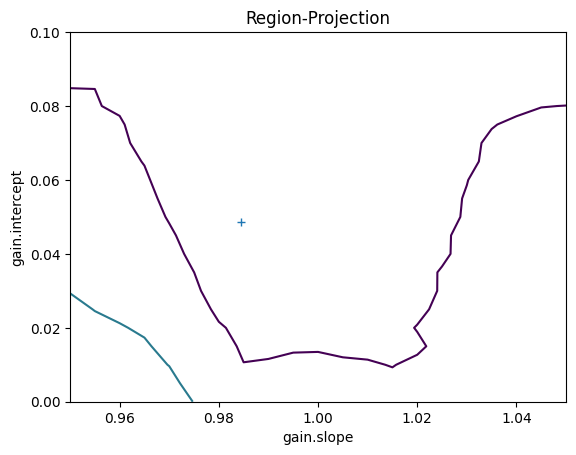

In [43]:
ui.reg_proj(gain.slope, gain.intercept, nloop=(21, 21), min=(0.95, 0), max=(1.05, 0.1))

So, no real evidence for a gain shift, but this is not really the dataset and source model to really check.